In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from keras._tf_keras.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras._tf_keras.keras import regularizers

In [15]:
np.random.seed(42)
DATADIR = r'./FER/train/'
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [16]:
def load_data():
    DATADIR = r'./FER/train/'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data
data = load_data()

100%|██████████| 3171/3171 [00:18<00:00, 172.30it/s]


In [17]:
len(data)

28709

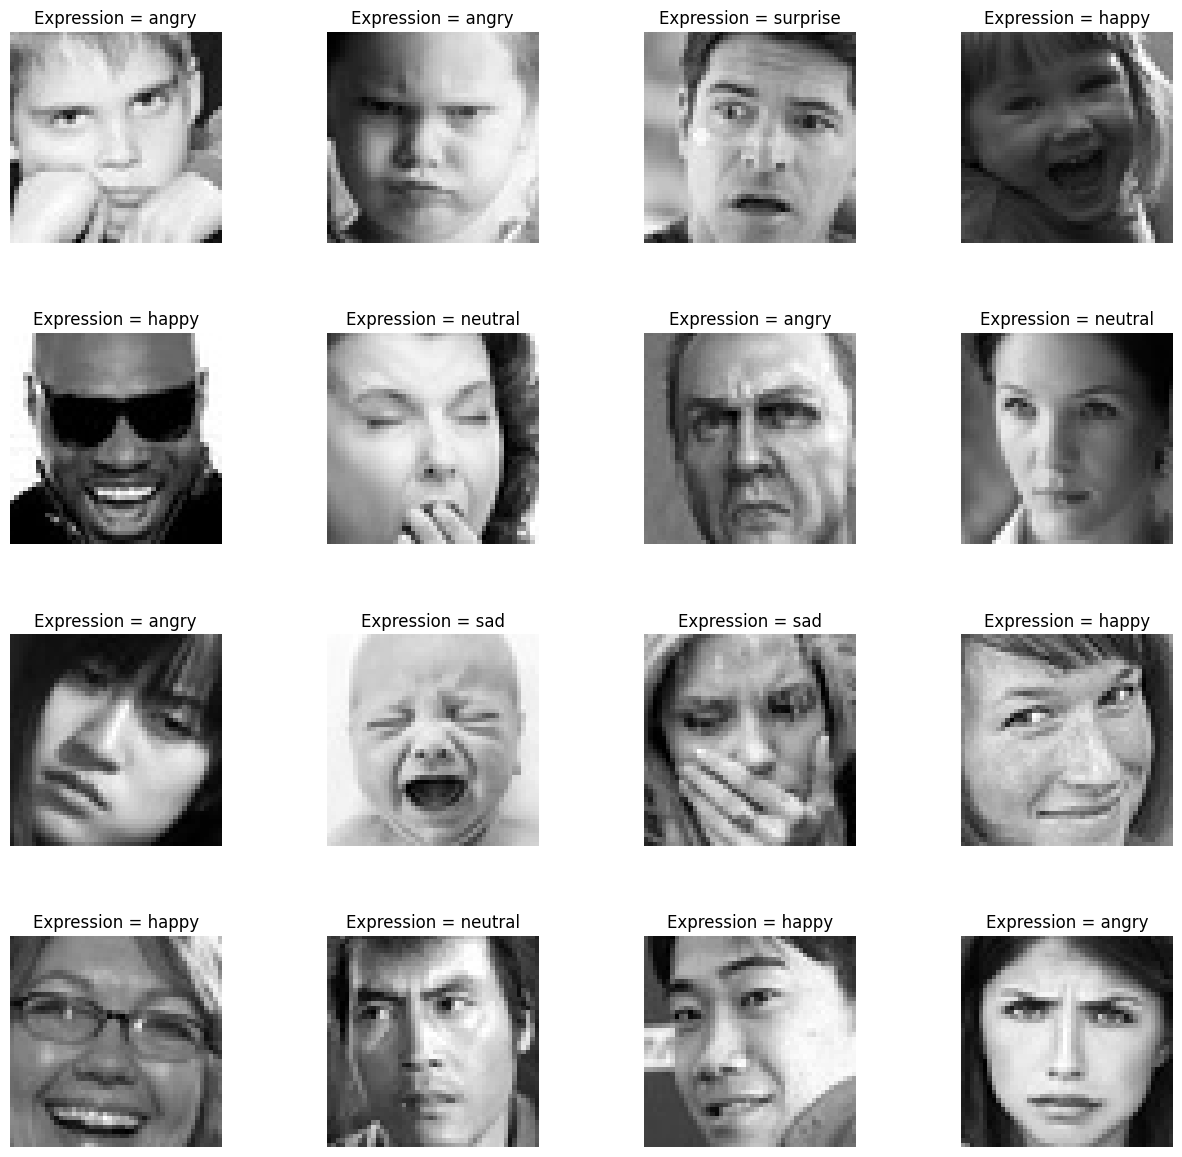

In [18]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [19]:
X = np.array([x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [21]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (22967, 48, 48)
y_train shape:  (22967,)
-------------------------------
X_test shape:  (5742, 48, 48)
y_test shape:  (5742,)


In [22]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (22967, 1)
y_test shape:  (5742, 1)


In [23]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (22967, 48, 48, 1)
X_test shape:  (5742, 48, 48, 1)


In [24]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [25]:
y_train[0]

array([4])

In [26]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [27]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.])

In [28]:
y_train.shape, y_test.shape

((22967, 7), (5742, 7))

In [29]:
def Binarypattern(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3                                              # taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values 
            img1_vector = np.delete(img1_vector,4)  
            digit = np.where(img1_vector)[0]         
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

(-0.5, 47.5, 47.5, -0.5)

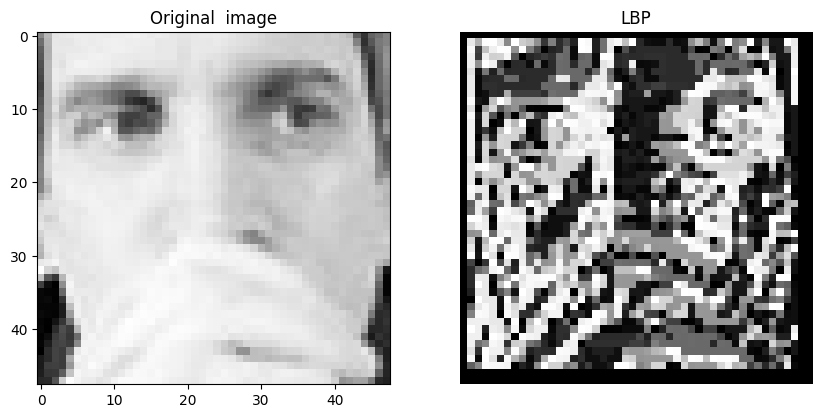

In [32]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
img = random.choice(X_train)
plt.title("Original  image")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("LBP")
imgLBP=Binarypattern(img)             # calling the LBP function using gray image
plt.imshow(imgLBP, cmap='gray')
plt.axis('off')

In [33]:
X_train.shape

(22967, 48, 48, 1)

In [34]:
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)  
        Feature_data[i] = imgLBP
    
    return Feature_data

In [35]:
Feature_X_train = create_LBP_features(X_train)

In [36]:
Feature_X_train.shape

(22967, 48, 48, 1)

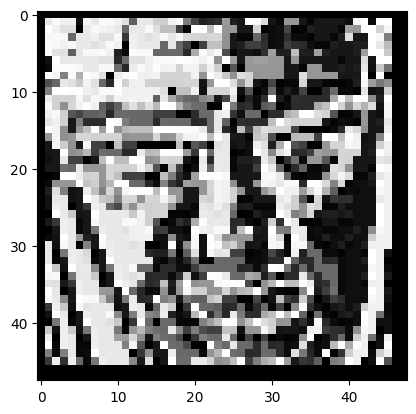

In [37]:
img = random.choice(Feature_X_train)
plt.imshow(img, cmap='gray')

In [38]:
Feature_X_test = create_LBP_features(X_test)
Feature_X_test.shape

(5742, 48, 48, 1)

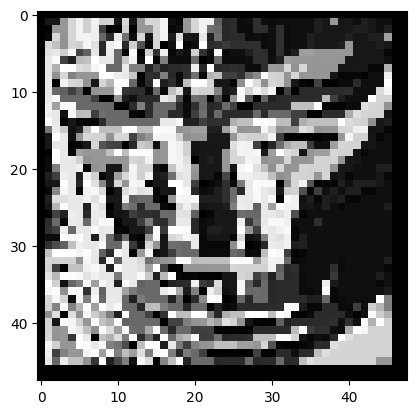

In [39]:
img = random.choice(Feature_X_test)
plt.imshow(img, cmap='gray')

In [40]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))
    
    return model 

es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [41]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=50, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.2417 - loss: 3.5540 - val_accuracy: 0.2567 - val_loss: 1.8111 - learning_rate: 0.0010
Epoch 2/50
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.2516 - loss: 1.8176 - val_accuracy: 0.2567 - val_loss: 1.8073 - learning_rate: 0.0010
Epoch 3/50
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2488 - loss: 1.8090 - val_accuracy: 0.2567 - val_loss: 1.8067 - learning_rate: 0.0010
Epoch 4/50
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.2496 - loss: 1.8130 - val_accuracy: 0.2567 - val_loss: 1.8071 - learning_rate: 0.0010
Epoch 5/50
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2516 - loss: 1.8132 - val_accuracy: 0.2567 - val_loss: 1.8070 - learning_rate: 0.0010
Epoch 6/50
2868/2871 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2463 - loss: 1.8122
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.24

In [43]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

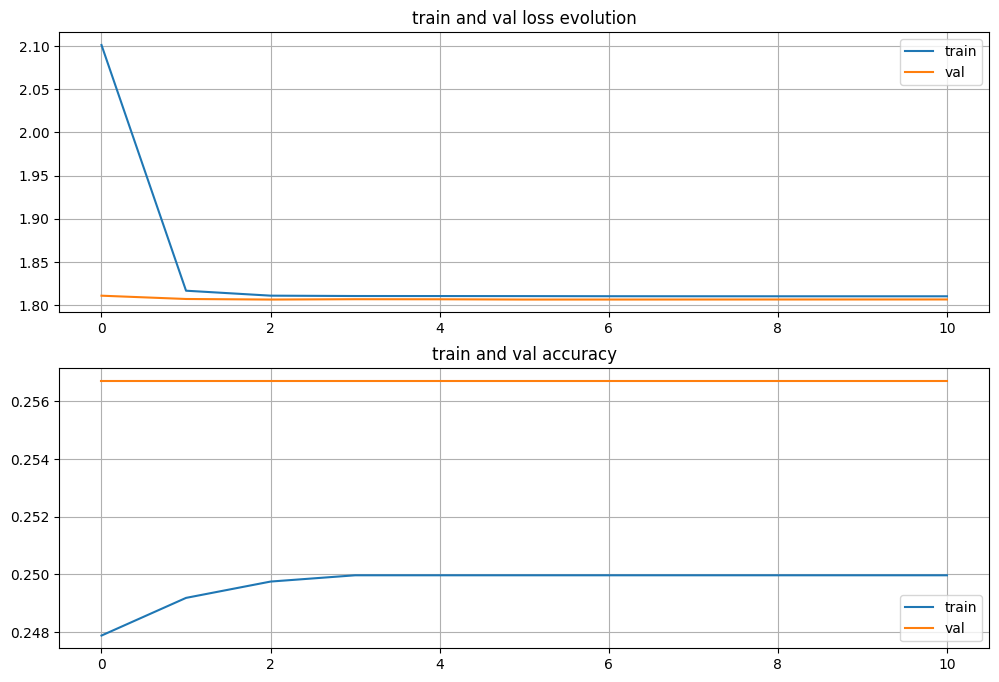

In [44]:
plot_performance(LBP_history)

In [45]:
LBP_acc = LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1]
print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])

LBP Accuracy : 0.25670498609542847
